In [1]:
import argparse
import os
import torch
import torch.nn as nn
from PIL import Image
from os.path import basename
from os.path import splitext
from torchvision import transforms
from torchvision.utils import save_image

def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def mean_variance_norm(feat):
    size = feat.size()
    mean, std = calc_mean_std(feat)
    normalized_feat = (feat - mean.expand(size)) / std.expand(size)
    return normalized_feat

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

class SANet(nn.Module):
    
    def __init__(self, in_planes):
        super(SANet, self).__init__()
        self.f = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.g = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.h = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.sm = nn.Softmax(dim = -1)
        self.out_conv = nn.Conv2d(in_planes, in_planes, (1, 1))
        
    def forward(self, content, style):
        F = self.f(mean_variance_norm(content))
        G = self.g(mean_variance_norm(style))
        H = self.h(style)
        b, c, h, w = F.size()
        F = F.view(b, -1, w * h).permute(0, 2, 1)
        b, c, h, w = G.size()
        G = G.view(b, -1, w * h)
        S = torch.bmm(F, G)
        S = self.sm(S)
        b, c, h, w = H.size()
        H = H.view(b, -1, w * h)
        O = torch.bmm(H, S.permute(0, 2, 1))
        b, c, h, w = content.size()
        O = O.view(b, c, h, w)
        O = self.out_conv(O)
        O += content
        return O

class Transform(nn.Module):
    def __init__(self, in_planes):
        super(Transform, self).__init__()
        self.sanet4_1 = SANet(in_planes = in_planes)
        self.sanet5_1 = SANet(in_planes = in_planes)
        self.upsample5_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.merge_conv_pad = nn.ReflectionPad2d((1, 1, 1, 1))
        self.merge_conv = nn.Conv2d(in_planes, in_planes, (3, 3))
    def forward(self, content4_1, style4_1, content5_1, style5_1):
        return self.merge_conv(self.merge_conv_pad(self.sanet4_1(content4_1, style4_1) + self.upsample5_1(self.sanet5_1(content5_1, style5_1))))

def test_transform():
    transform_list = []
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

parser = argparse.ArgumentParser()

# Basic options
parser.add_argument('--content', type=str, default = '/home/lzlzlizi/Pictures/zhaoji.jpg',
                    help='File path to the content image')
parser.add_argument('--style', type=str, default = '/home/lzlzlizi/Pictures/background/缺水的海怪的老婆.jpg',
                    help='File path to the style image, or multiple style \
                    images separated by commas if you want to do style \
                    interpolation or spatial control')
parser.add_argument('--steps', type=str, default = 1)
parser.add_argument('--vgg', type=str, default = 'vgg_normalised.pth')
parser.add_argument('--decoder', type=str, default = 'experiments/decoder_iter_500000.pth')
parser.add_argument('--transform', type=str, default = 'experiments/transformer_iter_500000.pth')

# Additional options
parser.add_argument('--save_ext', default = '.jpg',
                    help='The extension name of the output image')
parser.add_argument('--output', type=str, default = 'output',
                    help='Directory to save the output image(s)')

# Advanced options

args = parser.parse_args('')

device = torch.device("cuda:0")

if not os.path.exists(args.output):
    os.mkdir(args.output)

decoder = decoder
transform = Transform(in_planes = 512)
vgg = vgg

decoder.eval()
transform.eval()
vgg.eval()

decoder.load_state_dict(torch.load(args.decoder))
transform.load_state_dict(torch.load(args.transform))
vgg.load_state_dict(torch.load(args.vgg))

norm = nn.Sequential(*list(vgg.children())[:1])
enc_1 = nn.Sequential(*list(vgg.children())[:4])  # input -> relu1_1
enc_2 = nn.Sequential(*list(vgg.children())[4:11])  # relu1_1 -> relu2_1
enc_3 = nn.Sequential(*list(vgg.children())[11:18])  # relu2_1 -> relu3_1
enc_4 = nn.Sequential(*list(vgg.children())[18:31])  # relu3_1 -> relu4_1
enc_5 = nn.Sequential(*list(vgg.children())[31:44])  # relu4_1 -> relu5_1

norm.to(device)
enc_1.to(device)
enc_2.to(device)
enc_3.to(device)
enc_4.to(device)
enc_5.to(device)
transform.to(device)
decoder.to(device)

Sequential(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=2.0, mode=nearest)
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): ReflectionPad2d((1, 1, 1, 1))
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): ReflectionPad2d((1, 1, 1, 1))
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (12): ReLU()
  (13): ReflectionPad2d((1, 1, 1, 1))
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): Upsample(scale_factor=2.0, mode=nearest)
  (17): ReflectionPad2d((1, 1, 1, 1))
  (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (19): ReLU()
  (20): ReflectionPad2d((1, 1, 1, 1))
  (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (22): ReLU()
  (23): Upsample(scale_factor=2.0, mode=nearest)
  (24): ReflectionPad2d((1, 1, 1, 1))
  (25): Conv2d(64, 64, 

In [2]:
from skimage import color
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

def Preprocess(path):
    style =io.imread(path)
    if len(style.shape) == 2:
        style = color.gray2rgb(style)
    maxpix = 1024
    s_s = style.shape
    argmax = 0 if s_s[0] > s_s[1] else 1
    ratio = round(s_s[1-argmax] / s_s[argmax],2)
    if argmax == 0:
        newsize = (maxpix, int((maxpix*ratio))//16*16)
    else:
        newsize = (int((maxpix*ratio))//16*16, maxpix)
    style = resize(style, newsize,anti_aliasing=True)
    return style,(s_s[1],s_s[0])

def haha(out_dir, c_p, s_p):
    print(s_p)
    content_tf = test_transform()
    style_tf = test_transform()
    style,_ = Preprocess(s_p)
    content,original_size = Preprocess(c_p)
    style = torch.FloatTensor(style).permute((2,0,1))
    content = torch.FloatTensor(content).permute((2,0,1))
    style = style.to(device).unsqueeze(0)
    content = content.to(device).unsqueeze(0)
    
    with torch.no_grad():
        for x in range(1):
            Content4_1 = enc_4(enc_3(enc_2(enc_1(content))))
            Content5_1 = enc_5(Content4_1)

            Style4_1 = enc_4(enc_3(enc_2(enc_1(style))))
            Style5_1 = enc_5(Style4_1)

            style = decoder(transform(Content4_1, Style4_1, Content5_1, Style5_1))

            style.clamp(0, 255)

            style = style.cpu()

            output_name = '{:s}/{:s}_stylized_{:s}{}{:s}'.format(
                        out_dir, splitext(basename(c_p))[0],
                        splitext(basename(s_p))[0],x,args.save_ext
                    )

            save_image(style, output_name)
            style = content.to(device)

            im = Image.open(output_name)
            im = im.resize(original_size)
            im.save(output_name)
            
        

In [28]:
#multi-style
ps = '/home/lzlzlizi/Pictures/sketch/'
pic_ps = [os.path.join(ps,pp) for pp in os.listdir(ps)]
import shutil
shutil.rmtree('zj/')
os.mkdir('zj')
[haha('zj',c_p = '/home/lzlzlizi/Pictures/gaolu.jpg' , s_p =p ) for p in pic_ps]

/home/lzlzlizi/Pictures/sketch/Q (135).jpg
/home/lzlzlizi/Pictures/sketch/Q (183).jpg
/home/lzlzlizi/Pictures/sketch/Q (100).jpg
/home/lzlzlizi/Pictures/sketch/Q (127).jpg
/home/lzlzlizi/Pictures/sketch/Q (5).jpg
/home/lzlzlizi/Pictures/sketch/6a099eb8626947bf98f3c4e40bc4d028.jpg
/home/lzlzlizi/Pictures/sketch/Q (37).jpg
/home/lzlzlizi/Pictures/sketch/Q (53).jpg
/home/lzlzlizi/Pictures/sketch/d62b8290d01d46d49b8251367b38578f.jpg
/home/lzlzlizi/Pictures/sketch/1586b4065b494d90b33f43919e77c8ca.jpg
/home/lzlzlizi/Pictures/sketch/Q (153).jpg
/home/lzlzlizi/Pictures/sketch/Q (26).jpg
/home/lzlzlizi/Pictures/sketch/Q (52).jpg
/home/lzlzlizi/Pictures/sketch/Q (44).jpg
/home/lzlzlizi/Pictures/sketch/Q (55).jpg
/home/lzlzlizi/Pictures/sketch/Q (83).jpg
/home/lzlzlizi/Pictures/sketch/Q (38).jpg
/home/lzlzlizi/Pictures/sketch/Q (117).jpg
/home/lzlzlizi/Pictures/sketch/Q (214).jpg
/home/lzlzlizi/Pictures/sketch/Q (98).jpg
/home/lzlzlizi/Pictures/sketch/Q (119).jpg
/home/lzlzlizi/Pictures/sketch/Q 

KeyboardInterrupt: 

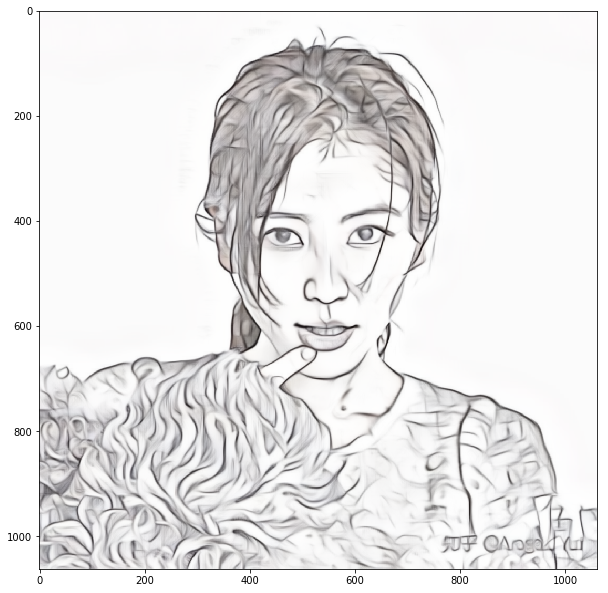

In [13]:
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np

ps = 'zj'
ps = [os.path.join(ps,p) for p in os.listdir(ps)]
average = np.average([cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in ps],axis=0).astype(np.uint8)
average.shape
plt.figure(figsize = (10,20))
plt.imshow(average,cmap='gray')
